In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
from gprofiler import GProfiler
import math

import itertools

In [2]:
# Import datasets and fused network from SNF
import import_ipynb
from SNF import prot, tran, epig, meta, fused_network, fused_labels

importing Jupyter notebook from SNF.ipynb


SNF.ipynb:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "cell_type": "code",


nx.html


In [3]:
fused_labels

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
      dtype=int32)

In [4]:
# to make labels match with clustering
def swap_labels(fused_labels):
    '''
    Labels are arbitrarily given as 0/1 by SNF. Swap labels to make them match with clustering. 
    Args:
        fused_labels: list of labels
    Returns:
        np.array with new labels (0 and 1 are swapped)
    '''
    new_labels = []
    for i in fused_labels:
        if i == 0:
            new_labels.append(1)
        else:
            new_labels.append(0)
    return np.array(new_labels)

fused_labels = swap_labels(fused_labels)

In [5]:
fused_labels

array([1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0])

In [6]:
def ttest_and_cluster(DE, c1, c2):
    '''
    Identify differentially expressed genes in each cluster by t-test
    Args:
        DE: DataFrame with original gene dataset
        cluster1: DataFrame with genes in cluster 1
        cluster2: DataFrame with genes in cluster 2
    Returns:
        cluster1: dictionary with key=gene name, value=P-value
        cluster2: dictionary with key=gene name, value=P-value
        pvals_corrected: list of Benjamini-Hochberg-corrected P-values
    '''
    t_tests = dict()
    pvals = []
    t_stats = []

    # Conduct t-tests for protein/gene in cluster1 vs. cluster2
    for colName, colData in DE.iteritems():
        result = ttest_ind(c1[colName], c2[colName], equal_var=False)
        t_tests[colName] = result
        t_stats.append(result.statistic)
        pvals.append(result.pvalue)
    # Multiple test correction
    mult_result = multipletests(pvals, alpha = 0.1, method='fdr_bh')
    
    reject, pvals_corrected = list(mult_result[0]), list(mult_result[1])
    # Group differentially expressed proteins by cluster
    cluster1 = dict()
    cluster2 = dict()

    for i, item in enumerate(DE.columns):
        if reject[i]:
            pval_corrected = pvals_corrected[i]
            # if t-stat > 0, protein/gene is differentially expressed in cluster1
            if t_stats[i] > 0:
                cluster1[item] = pval_corrected
            else:
                cluster2[item] = pval_corrected
    
    print("cluster 1 length: " + str(len(cluster1)))
    print("cluster 2 length: " + str(len(cluster2)))
    print("# DE: " + str(len(cluster1) + len(cluster2)))
    return [cluster1, cluster2], pvals_corrected

In [7]:
def set_thresholds(d):
    '''
    Set thresholds for differential expression in volcano plot
    Args:
        d: string of either proteomics, transcriptomics, or epigenomics
    Returns:
        log2FC threshold, -log10(adj P) threshold
    '''
    if d == 'proteomics':
        return 0.03, 10   # good for reg
    if d == 'transcriptomics':
        return 0.2, 15
    else:
        return 0.1, 15

In [8]:
def log_scores(d, DE, c1, c2, pvals_corrected):
    '''
    Calculate log2FC and -log10(adj P)
    Args:
        d: string of either proteomics, transcriptomics, or epigenomics
        DE: DataFrame with original gene dataset
        cluster1: DataFrame with genes in cluster 1
        cluster2: DataFrame with genes in cluster 2
        pvals_corrected: list of Benjamini-Hochberg-corrected P-values
    Returns:
        VP_df: DataFrame with log2FC and -log10(adj P) for each gene
    '''
    # Calculate log2FC and -log10(adj P)
    log2FC = []
    nlog10P = []
    for i, item in enumerate(DE.columns):
        FC = c1[item].mean()/c2[item].mean()
        log2FC.append(math.log2(FC))
        nlog10P.append(-math.log10(pvals_corrected[i]))
    VP_df = pd.DataFrame({d: DE.columns, 'log2FC': log2FC, 'nlog10P': nlog10P})
    
    return VP_df

In [9]:
def map_color(a, clusters, log2FC_t, nlog10P_t):
    '''
    Add color to plot by cluster
    '''
    log2FC, symbol, nlog10P = a
    cluster1, cluster2 = clusters[0], clusters[1]
    if abs(log2FC) < log2FC_t or nlog10P < nlog10P_t:
        return 'none'
    if symbol in cluster1.keys():
        return 'cluster1'
    if symbol in cluster2.keys():
        return 'cluster2'

In [10]:
def volcano_plot(d, VP_df, log2FC_threshold, nlog10P_threshold):
    '''
    Create volcano plot
    '''
    plt.figure(figsize=(6,6))
    ax = sns.scatterplot(data=VP_df, x='log2FC', y='nlog10P',
                         hue='color', palette=['lightgrey', 'blue', 'green'])

    ax.axhline(nlog10P_threshold, zorder=0, c='k', lw=1, ls='--')
    ax.axvline(-log2FC_threshold, zorder=0, c='k', lw=1, ls='--')
    ax.axvline(log2FC_threshold, zorder=0, c='k', lw=1, ls='--')

    # Label names for proteomics
    # Too many names to label for other datasets
    if d == 'proteomics':
        texts = []
        for i in range(len(VP_df)):
            if VP_df.iloc[i].nlog10P > nlog10P_threshold and \
            abs(VP_df.iloc[i].log2FC) > log2FC_threshold:
                texts.append(plt.text(VP_df.iloc[i].log2FC,
                                      y=VP_df.iloc[i].nlog10P,
                                      s=VP_df.iloc[i].proteomics))

    plt.show()

In [11]:
import mygene
mg = mygene.MyGeneInfo()

def clean_proteomics_gene_names(names):
    '''
    Get correct proteomics gene names for GO
    '''
    results = mg.querymany(names.uniprot.values, 
                           scopes=['uniprot'], fields=["symbol"], species="human",
                           as_dataframe=True, returnall=True)
    duplicated = results['dup']
    missing = results['missing']
    out = results['out']
    # add back column
    out['uniprot'] = out.index.values
    prot_df = out.drop_duplicates(subset=['uniprot'])
    merged = prot_df.merge(names, how='outer', on='uniprot')
    merged['final_name'] = merged.apply(lambda row: row['symbol'] if np.isnan(row['notfound']) else row['original_name'],
                                   axis=1)
    return merged.final_name.values.tolist()


In [12]:
# hypergeometric test for expression
def get_GO_terms(d, clusters, go_background):
    '''
    Get GO terms for genes in each cluster
    Args:
        d: string of either proteomics, transcriptomics, or epigenomics
        clusters: list of [cluster1, cluster2]
            cluster1: list of genes in cluster 1
            cluster2: list of genes in cluster 2
        go_background: list of background genes
    Returns:
        clusters_go: list of cluster_go for each cluster
            cluster_go: DataFrame output of gprofiler
    '''
    sourcelist = ['GO:MF', 'GO:BP', 'KEGG']
    clusters_go = []
    gp = GProfiler(return_dataframe=True)

    for cluster in clusters:
        cluster_go = gp.profile(organism='hsapiens',
                                query=cluster,
                                sources=sourcelist,
                                domain_scope='custom',
                                background=go_background,
                                significance_threshold_method="fdr",
                                user_threshold=0.1)
        clusters_go.append(cluster_go)
    
    return clusters_go

In [13]:
from matplotlib import colors
from matplotlib import rcParams

def scale_data_5_75(data):
    mind = np.min(data)
    maxd = np.max(data)
    
    if maxd == mind:
        maxd=maxd+1
        mind=mind-1
        
    drange = maxd - mind
    return ((((data - mind)/drange*0.70)+0.05)*100)


def plot_enrich(data, n_terms=20, save=False):
    '''
    Make plot of top 10 GO terms
    Args:
        data: DataFrame output by gprofiler
    '''
    # Test data input
    if not isinstance(data, pd.DataFrame):
        raise ValueError('Please input a Pandas Dataframe output by gprofiler.')
        
    if not np.all([term in data.columns for term in ['p_value', 'name', 'intersection_size']]):
        raise TypeError('The data frame {} does not contain enrichment results from gprofiler.'.format(data))
    
    data_to_plot = data.iloc[:n_terms,:].copy()
    data_to_plot['go.id'] = data_to_plot.index

    min_pval = data_to_plot['p_value'].min()
    max_pval = data_to_plot['p_value'].max()
    
    # Scale intersection_size to be between 5 and 75 for plotting
    #Note: this is done as calibration was done for values between 5 and 75
    data_to_plot['scaled.overlap'] = scale_data_5_75(data_to_plot['intersection_size'])
    
    norm = colors.LogNorm(min_pval, max_pval)
    sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
    sm.set_array([])

    rcParams.update({'font.size': 14, 'font.weight': 'bold'})

    sns.set(style="whitegrid")

    path = plt.scatter(x='recall', y="name", c='p_value', cmap='cool', 
                       norm=colors.LogNorm(min_pval, max_pval), 
                       data=data_to_plot, linewidth=1, edgecolor="grey", 
                       s=[(i+10)**1.5 for i in data_to_plot['scaled.overlap']])
    ax = plt.gca()
    ax.invert_yaxis()

    ax.set_ylabel('')
    ax.set_xlabel('Gene ratio', fontsize=14, fontweight='bold')
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Get tick marks for this plot
    #Note: 6 ticks maximum
    min_tick = np.floor(np.log10(min_pval)).astype(int)
    max_tick = np.ceil(np.log10(max_pval)).astype(int)
    tick_step = np.ceil((max_tick - min_tick)/6).astype(int)
    
    # Ensure no 0 values
    if tick_step == 0:
        tick_step = 1
        min_tick = max_tick-1
    
    ticks_vals = [10**i for i in range(max_tick, min_tick-1, -tick_step)]
    ticks_labs = ['$10^{'+str(i)+'}$' for i in range(max_tick, min_tick-1, -tick_step)]

    #Colorbar
    fig = plt.gcf()
    cbaxes = fig.add_axes([0.8, 0.15, 0.03, 0.4])
    cbar = ax.figure.colorbar(sm, ticks=ticks_vals, shrink=0.5, anchor=(0,0.1), cax=cbaxes)
    cbar.ax.set_yticklabels(ticks_labs)
    cbar.set_label("Adjusted p-value", fontsize=14, fontweight='bold')

    #Size legend
    min_olap = data_to_plot['intersection_size'].min()
    max_olap = data_to_plot['intersection_size'].max()
    olap_range = max_olap - min_olap
    
    #Note: approximate scaled 5, 25, 50, 75 values are calculated
    #      and then rounded to nearest number divisible by 5
    size_leg_vals = [np.round(i/5)*5 for i in 
                          [min_olap, min_olap+(20/70)*olap_range, min_olap+(45/70)*olap_range, max_olap]]
    size_leg_scaled_vals = scale_data_5_75(size_leg_vals)

    
    l1 = plt.scatter([],[], s=(size_leg_scaled_vals[0]+10)**1.5, edgecolors='none', color='black')
    l2 = plt.scatter([],[], s=(size_leg_scaled_vals[1]+10)**1.5, edgecolors='none', color='black')
    l3 = plt.scatter([],[], s=(size_leg_scaled_vals[2]+10)**1.5, edgecolors='none', color='black')
    l4 = plt.scatter([],[], s=(size_leg_scaled_vals[3]+10)**1.5, edgecolors='none', color='black')

    labels = [str(int(i)) for i in size_leg_vals]

    leg = plt.legend([l1, l2, l3, l4], labels, ncol=1, frameon=False, fontsize=12,
                     handlelength=1, loc = 'center left', borderpad = 1, labelspacing = 1.4,
                     handletextpad=2, title='Gene overlap', scatterpoints = 1,  bbox_to_anchor=(-2, 1.5), 
                     facecolor='black')

    if save:
        plt.savefig(save, dpi=300, format='pdf')

    plt.show()

In [14]:
# Only need to run once to get epigenomic peaks as a txt file
'''
# Annotate epigenomic regions
epig_regions = [c.split('-') for c in epig.columns]
n = len(epig_regions)
epig_pos = pd.DataFrame({'Unique Peak ID': epig.columns,
                         'chromosome': [c[0] for c in epig_regions],
                         'starting position': [c[1] for c in epig_regions],
                         'ending position': [c[2] for c in epig_regions],
                         'Strand': ['+']*n})
epig_pos.to_csv('peaks_pos.txt', sep='\t', index=False)
'''

"\n# Annotate epigenomic regions\nepig_regions = [c.split('-') for c in epig.columns]\nn = len(epig_regions)\nepig_pos = pd.DataFrame({'Unique Peak ID': epig.columns,\n                         'chromosome': [c[0] for c in epig_regions],\n                         'starting position': [c[1] for c in epig_regions],\n                         'ending position': [c[2] for c in epig_regions],\n                         'Strand': ['+']*n})\nepig_pos.to_csv('peaks_pos.txt', sep='\t', index=False)\n"

In [15]:
def get_annotations_dict():
    '''
    Import epigenomic region annotations
    '''
    annotations = pd.read_csv('annotations_pos.txt',sep='\t')
    annotations = annotations[annotations['Nearest Ensembl'].notna()]
    return dict(zip(list(annotations['PeakID (cmd=annotatePeaks.pl peaks_pos.txt hg38)']),
                    list(annotations['Nearest Ensembl'])))

Main chunk of code to run

INFO:biothings.client:querying 1-1000...


proteomics
total: 3496


INFO:biothings.client:done.
INFO:biothings.client:querying 1001-2000...
INFO:biothings.client:done.
INFO:biothings.client:querying 2001-3000...
INFO:biothings.client:done.
INFO:biothings.client:querying 3001-3496...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


# patients in cluster 1: 95
# patients in cluster 2: 101
cluster 1 length: 981
cluster 2 length: 1045
# DE: 2026


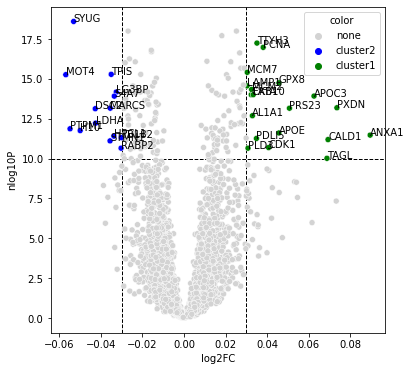

cluster 1


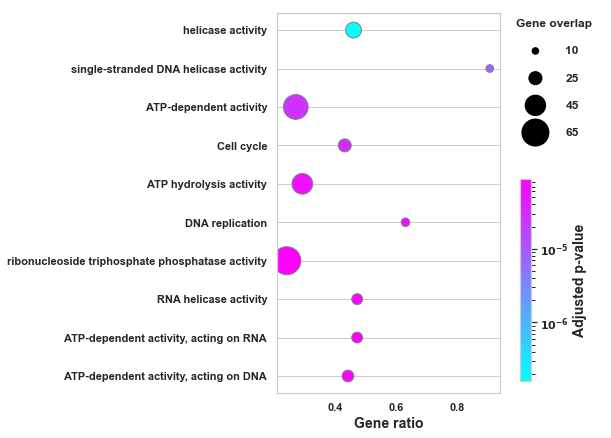

cluster 2
transcriptomics
total: 24711
# patients in cluster 1: 95
# patients in cluster 2: 101
cluster 1 length: 9184
cluster 2 length: 8728
# DE: 17912


<Figure size 360x504 with 0 Axes>

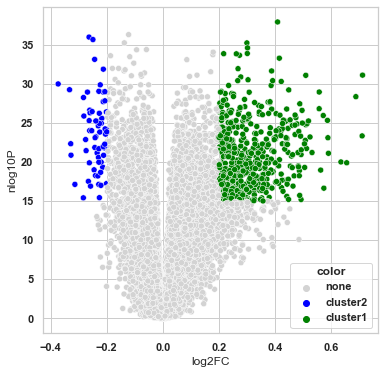

cluster 1


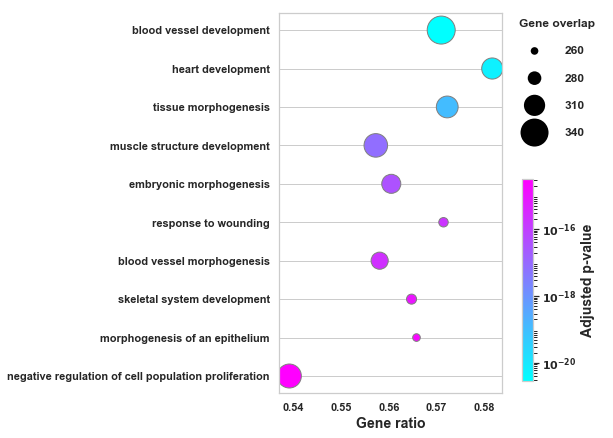

cluster 2


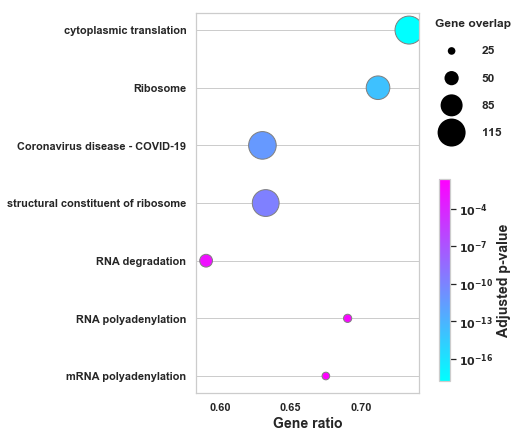

epigenomics
total: 100363
# patients in cluster 1: 95
# patients in cluster 2: 101
cluster 1 length: 30568
cluster 2 length: 29983
# DE: 60551


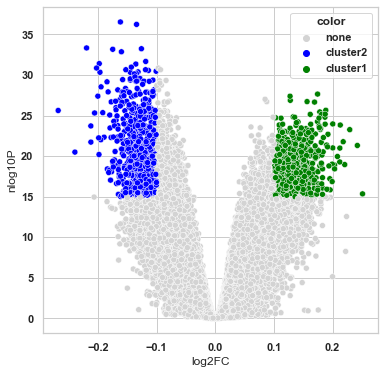

cluster 1


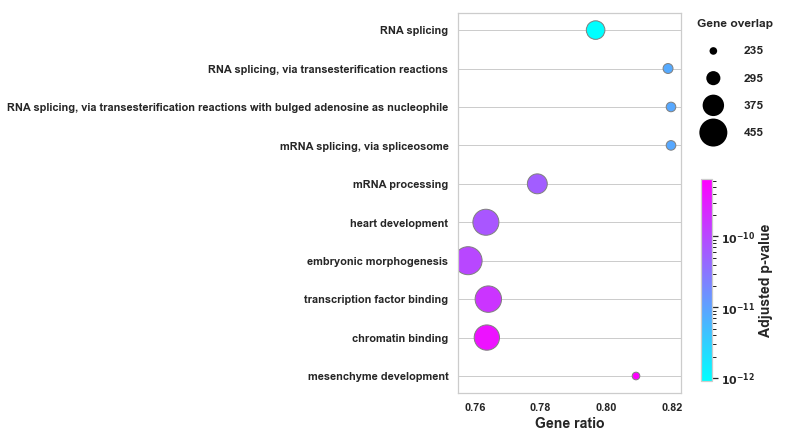

cluster 2


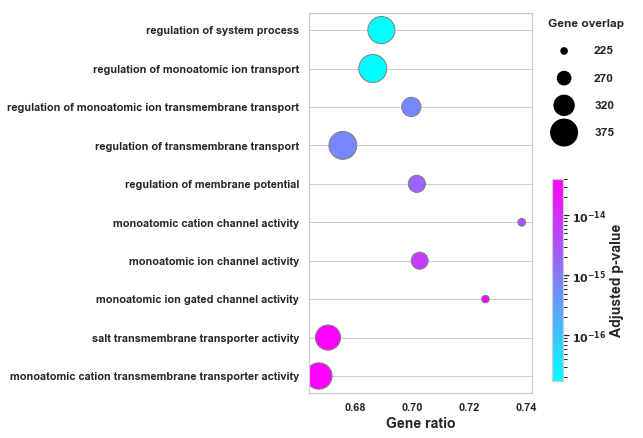

In [16]:
data = {'proteomics': [prot], 'transcriptomics': [tran], 'epigenomics': [epig]}

# Iterate over each modality
for d in data:
    print(d)
    DE = data[d][0].copy()
    print("total: " + str(len(DE.columns)))
    if d == 'proteomics':
        # Keep only protein names, not Uniprot IDs
        names = pd.DataFrame([name.split('|') for name in DE.columns],
                             columns = ['uniprot', 'original_name'])
        go_background = clean_proteomics_gene_names(names)
        DE.set_axis(names['original_name'], axis=1, inplace=True)
    else:
        go_background = DE.columns.tolist()

    # Split proteins by cluster
    DE['fused_labels'] = fused_labels
    c1 = DE[DE['fused_labels']==0]
    print("# patients in cluster 1: " + str(len(c1)))
    c2 = DE[DE['fused_labels']==1]
    print("# patients in cluster 2: " + str(len(c2)))
    DE.drop('fused_labels', axis=1, inplace=True)
    
    clusters, pvals_corrected = ttest_and_cluster(DE, c1, c2)
    
    # Volcano plot
 
    # Set thresholds
    log2FC_threshold, nlog10P_threshold = set_thresholds(d)
        
    VP_df = log_scores(d, DE, c1, c2, pvals_corrected)
    VP_df['color'] = VP_df[['log2FC', d, 'nlog10P']].apply(map_color,
                                                           clusters=clusters,
                                                           log2FC_t=log2FC_threshold,
                                                           nlog10P_t=nlog10P_threshold,
                                                           axis=1)
    volcano_plot(d, VP_df, log2FC_threshold, nlog10P_threshold)

    cluster_names = dict()

    # GO terms
    
    # Get epigenomic annotations
    if d == 'epigenomics':
        annotations_dict = get_annotations_dict()
        go_background = list(annotations_dict.values())
        for i, cluster in enumerate(clusters):
            cluster_names[i] = []
            for e in list(cluster.keys()):
                if e in annotations_dict:
                    cluster_names[i].append(annotations_dict[e])
            
            data[d].append(cluster_names[i])
    else:
        for i, cluster in enumerate(clusters):
            cluster_names[i] = list(cluster.keys())
            data[d].append(cluster_names[i])
    
    # Get GO terms
    go_terms = get_GO_terms(d, list(cluster_names.values()), go_background)
    data[d].append(go_terms)
    
    # Plot top 10 GO terms
    for i, go in enumerate(go_terms):
        print("cluster " + str(i+1))
        #plt.figure(figsize=(5,7))
        #plot_enrich(go, n_terms=10)
        go = go[go['term_size'] < 600]
        plt.figure(figsize=(5,7))
        if not go.empty: # second cluster is empty for proteomics & epigenomics?
            plot_enrich(go, n_terms=10)

### Compare clusters from different modalities

In [17]:
def print_comparisons(mod1, mod2, mod1_c1, mod1_c2, mod2_c1, mod2_c2):
    print(mod1 + " 1: " + str(len(mod1_c1)))
    print(mod1 + " 2: " + str(len(mod1_c2)))
    print(mod2 + " 1: " + str(len(mod2_c1)))
    print(mod2 + " 2: " + str(len(mod2_c2)))
    print(mod1 + " 1, " + mod2 + " 1 overlap: " + str(len(mod1_c1 & mod2_c1)))
    print(mod1 + " 1, " + mod2 + " 2 overlap: " + str(len(mod1_c1 & mod2_c2)))
    print(mod1 + " 2, " + mod2 + " 2 overlap: " + str(len(mod1_c2 & mod2_c2)))
    print(mod1 + " 2, " + mod2 + " 1 overlap: " + str(len(mod1_c2 & mod2_c1)))

def compare_raw(mod1, mod2):
    '''
    Print overlap in genes in clusters 1 and 2 in different modalities
    '''
    mod1_c1 = set(data[mod1][1])
    mod1_c2 = set(data[mod1][2])
    mod2_c1 = set(data[mod2][1])
    mod2_c2 = set(data[mod2][2])
    print_comparisons(mod1, mod2, mod1_c1, mod1_c2, mod2_c1, mod2_c2)
    
compare_raw("transcriptomics", "epigenomics")
compare_raw("transcriptomics", "proteomics")

transcriptomics 1: 9184
transcriptomics 2: 8728
epigenomics 1: 12998
epigenomics 2: 10290
transcriptomics 1, epigenomics 1 overlap: 4588
transcriptomics 1, epigenomics 2 overlap: 2991
transcriptomics 2, epigenomics 2 overlap: 2842
transcriptomics 2, epigenomics 1 overlap: 3154
transcriptomics 1: 9184
transcriptomics 2: 8728
proteomics 1: 981
proteomics 2: 1045
transcriptomics 1, proteomics 1 overlap: 0
transcriptomics 1, proteomics 2 overlap: 0
transcriptomics 2, proteomics 2 overlap: 0
transcriptomics 2, proteomics 1 overlap: 0


In [18]:
def compare_GO(mod1, mod2):
    '''
    Print overlap in GO terms in clusters 1 and 2 in different modalities
    '''
    mod1_c1 = set(data[mod1][3][0]['native'])
    mod1_c2 = set(data[mod1][3][1]['native'])
    mod2_c1 = set(data[mod2][3][0]['native'])
    mod2_c2 = set(data[mod2][3][1]['native'])
    print_comparisons(mod1, mod2, mod1_c1, mod1_c2, mod2_c1, mod2_c2)
    print()

compare_GO("transcriptomics", "epigenomics")
compare_GO("transcriptomics", "proteomics")

transcriptomics 1: 2739
transcriptomics 2: 29
epigenomics 1: 999
epigenomics 2: 953
transcriptomics 1, epigenomics 1 overlap: 723
transcriptomics 1, epigenomics 2 overlap: 594
transcriptomics 2, epigenomics 2 overlap: 0
transcriptomics 2, epigenomics 1 overlap: 25

transcriptomics 1: 2739
transcriptomics 2: 29
proteomics 1: 367
proteomics 2: 0
transcriptomics 1, proteomics 1 overlap: 267
transcriptomics 1, proteomics 2 overlap: 0
transcriptomics 2, proteomics 2 overlap: 0
transcriptomics 2, proteomics 1 overlap: 3



### Covariates vs. DEGs

In [19]:
def covariate_correlation(c, modality, r_threshold):
    '''
    Calculate correlation of features with biological covariates
    Args:
        c: string of covariate
        modality: string of modality
        r_threshold: int of r threshold for correlation btwn feature and covariate
    Returns:
        genes: dictionary with key=gene name, value=r (correlation coeff btwn feature and covariate)
    '''
    cov = meta[c]
    drop = meta[cov.isna()].index.values
    cov = cov.dropna()
    modality = modality.drop(drop, axis=0)
    
    genes = dict()
    r_vals = []
    
    for col, colData in modality.iteritems():
        r = spearmanr(cov, colData)[0]
        r_vals.append(r)
        if r < -r_threshold or r > r_threshold:
            genes[col] = r

    return genes, r_vals

#### Transcriptomics

In [20]:
covariates = ['nefh', 'isl1', 'nkx6', 'tuj1', 's100b']
DEGs = data['transcriptomics'][1] + data['transcriptomics'][2]

for c in covariates:
    print(c)
    genes, r_vals = covariate_correlation(c, tran, 0.7)
    #plt.figure()
    #plt.hist(r_vals)
    
    print("highly correlated genes: " + str(len(genes)))
    print("overlap w/ DEGs: " + str(len(set(genes.keys()) & set(DEGs))))

nefh
highly correlated genes: 0
overlap w/ DEGs: 0
isl1
highly correlated genes: 0
overlap w/ DEGs: 0
nkx6
highly correlated genes: 0
overlap w/ DEGs: 0
tuj1
highly correlated genes: 0
overlap w/ DEGs: 0
s100b
highly correlated genes: 286
overlap w/ DEGs: 286


In [21]:
# Identify genes most highly correlated with s100b
"""
cov = meta['s100b']
drop = meta[cov.isna()].index.values
cov = cov.dropna()
tran = tran.drop(drop, axis=0)
"""

s100b_genes = dict(sorted(genes.items(), key=lambda x:x[1], reverse=True))
s100b_genes = dict(itertools.islice(s100b_genes.items(), 20))


for gene in s100b_genes:
    print(gene)
    plt.figure()
    plt.scatter(cov, tran[gene])
    plt.xlabel(c)
    plt.ylabel(gene)
    
    test = ttest_ind(cov, tran[gene])
    plt.annotate("p = {:.3f}".format(test.pvalue) + \
                 ", r = {:.3f}".format(s100b_genes[gene]),
                 (0.05, 0.9),
                 xycoords='axes fraction')
    plt.show()

ENSG00000116729


NameError: name 'cov' is not defined

<Figure size 432x288 with 0 Axes>

In [ ]:
# Get GO terms for genes most highly correlated with s100b
gp = GProfiler(return_dataframe=True)
s100b_go = gp.profile(organism='hsapiens',
                      query=list(s100b_genes.keys()),
                      sources=['GO:MF', 'GO:BP', 'KEGG'],
                      domain_scope='custom',
                      background=tran.columns.tolist(),
                      significance_threshold_method="fdr",
                      user_threshold=0.1,
                      no_evidences=False)

s100b_go['intersections'][0]

In [ ]:
# Plot top 10 GO terms for genes highly correlated with s100b
s100b_go = s100b_go[s100b_go['term_size'] < 600]
plt.figure(figsize=(5,7))
plot_enrich(s100b_go, n_terms=10)

In [ ]:
# Print overlap between GO terms for differentially expressed genes and genes highly correlated with s100b
DEGs_go = set(data['transcriptomics'][3][0]['native']) & set(data['transcriptomics'][3][1]['native'])
print(len(DEGs_go))
print(len(s100b_go['native']))
len(set(s100b_go['native']) & DEGs_go)

#### Proteomics

In [ ]:
DEGs = data['proteomics'][1] + data['proteomics'][2]

for c in covariates:
    print(c)
    proteins, r_vals = covariate_correlation(c, prot, 0.4)
    #plt.figure()
    #plt.hist(r_vals)

    # Keep only protein names, not Uniprot IDs
    proteins = [prot.split('|')[-1] for prot in proteins]

    print("highly correlated proteins: " + str(len(proteins)))
    print("overlap w/ DEGs: " + str(len(set(proteins) & set(DEGs))))